In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger
Example for the package
"""

'\nName: example.ipynb\nAuthors: Stephan Meighen-Berger, Martina Karl\nExample for the package\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
config['scenario']['population size'] = 1000
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 6.,
    'y_length': 3.
}
config['organisms']['emission fraction'] = 0.5

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

In [9]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Paraphyllina ransoni Russell,6.018237,1.974774,0.005927,3.806633,0.001058,0.029,False,27.505491,0.5,0.001,False,-10.0,0.0,0.0,0.0
1,Aeginura grimaldii Maas,5.309672,1.230955,0.004569,0.920616,0.000768,1.000,True,8.393156,0.5,0.001,False,-100.0,0.0,0.0,0.0
2,Praya dubia (Quoy and Gaimard),5.183954,2.287492,0.002379,1.003538,0.000792,0.075,True,8.974659,0.5,0.001,False,-60.0,0.0,0.0,0.0
3,Nectopyramis natans (Bigelow),6.024420,1.275671,0.007353,3.907850,0.000959,1.000,False,9.558992,0.5,0.001,False,-6.0,0.0,0.0,0.0
4,Periphyllopsis braueri Vanhoeffen,6.012765,2.195355,0.003542,3.491535,0.001093,0.037,False,10.711722,0.5,0.001,False,-12.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Apolemia sp. 2,0.000000,1.546692,0.000000,0.000000,0.001120,1.000,True,6.134106,0.5,0.001,False,0.0,0.0,0.0,0.0
1496,Mertensiidae gen. nov. B sp. nov. Dad,0.000000,2.745247,0.000000,0.000000,0.000542,1.000,True,23.024275,0.5,0.001,False,0.0,0.0,0.0,0.0
1497,Nectopyramis natans (Bigelow),0.000000,1.358486,0.000000,0.000000,0.000737,1.000,True,5.191917,0.5,0.001,False,0.0,0.0,0.0,0.0
1498,Apolemia sp. 1,0.000000,0.955620,0.000000,0.000000,0.001147,1.000,True,9.873841,0.5,0.001,False,0.0,0.0,0.0,0.0


In [10]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=3.
h_length=1.5

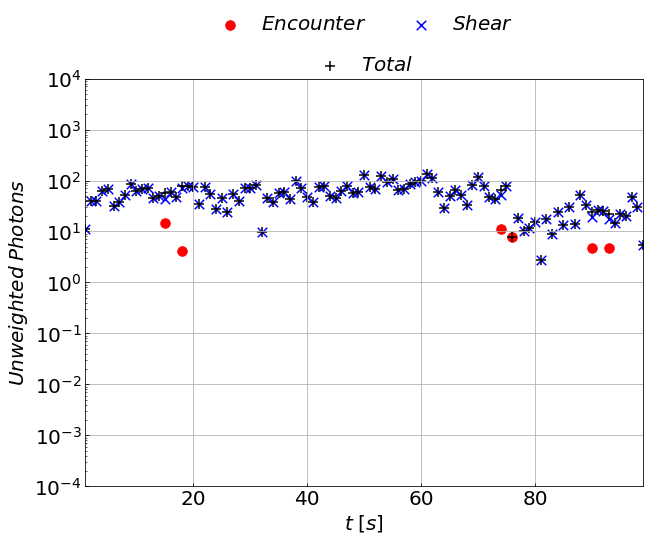

In [11]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
data_enc = np.array([np.sum(fd.statistics[i].loc[:, 'encounter photons'].values)
                     for i in range(len(fd.t))])
data_shear = np.array([np.sum(fd.statistics[i].loc[:, 'shear photons'].values)
                       for i in range(len(fd.t))])
data = np.array([np.sum(fd.statistics[i].loc[:, 'photons'].values)
                     for i in range(len(fd.t))])
ax1.scatter(fd.t,
            data_enc,
            s=lw*30, color='r', label=r'$Encounter$', marker="o")
ax1.scatter(fd.t,
            data_shear,
            s=lw*30, color='b', label=r'$Shear$', marker="x")
ax1.scatter(fd.t,
            data,
            s=lw*30, color='k', label=r'$Total$', marker="+")
ax1.set_xlim(1e0, max(fd.t))
ax1.set_ylim(1e-4, 1e4)
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(h[2:],l[2:], loc=9, bbox_to_anchor=(0.5, +1.1),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.show()

In [12]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')